In [1]:
import pandas as pd
import numpy as np
import re
import os.path
import io
from bs4 import BeautifulSoup

In [2]:
text_files = '/Users/home/LiberatingArchives/corpus'

In [3]:
all_text = []
for file in os.listdir(text_files):
    if file != '.DS_Store':
        all_text.append(os.path.join(text_files, file))

In [41]:
# Global Lists for all Texts
all_titles = []
all_dates = []
all_post_id = []
all_locations = []
all_categories = [] # list within list
all_entry_content = []

# Global Lists for Legislation Texts
all_bills = pd.DataFrame()

# Global Lists for Appointments
app_post_id = []
app_dates = []
app_name = []
app_gender = []
app_party = []
app_full_descr = []
app_entry_content = []

In [42]:
cats = set()

In [43]:
for textFile in all_text: # Change to length of list
    with open(textFile, "r") as f:
        curr_text = f.read()
    #
    all_titles.append(re.findall("""<h1 class=\"[^\"]+\".*?>(.+?)<\/h1>""", curr_text)[0])
    try:
        date = re.findall("""Published: <time datetime=\"(.*?)\"""", curr_text)[0]
    except IndexError:
        date = np.nan # Date not specified in text file. There is 1 occurrence.
    
    all_dates.append(date)
        
    post_id = int(re.findall("""<article id=\"post-([\d]+)\"""", curr_text)[0])
    categories = re.findall("""category-([\w-]+)""", curr_text)
    
    all_post_id.append(post_id)
    all_categories.append(categories)
    
    cats.update(categories)
    
    curr1_text = re.findall("""<div class=\"entry-content\">([\s\S]+?)<!-- .et_pb_post -->""", curr_text)
    souped = BeautifulSoup(curr1_text[0], 'html.parser')
    text_parsed = souped.get_text()
    
    all_entry_content.append(text_parsed)
    
    try:
        all_locations.append(re.findall('([A-Z][A-Z| ]+)', text_parsed)[0])
    except IndexError:
        all_locations.append(np.nan)
    
    
    #
    if 'appointments' in categories:
        apps = [app for app in re.split('\n', text_parsed) if not app.isspace() and app != '' and app != '###'][1:]
        
        prev = -1
        for app in apps:
            flag = True
            #print(app)
            
            try:
                name = re.findall('^(?:[•|–]\t)?(?:– )?(.+?),', app)[0] 
                app_name.append(name)
                if 'compensation' in name:
                    
                    app_full_descr[prev] = app_full_descr[prev] + ' ' + name
                    flag = False
                    
            except IndexError:
                if flag:
                    app_name.append('')
            
            if True:
                app_post_id.append(post_id)
                app_dates.append(date)
                
                if 'She ' in app or ' she ' in app or 'female' in app or 'lesbian' in app:
                    app_gender.append('F')
                elif 'He ' in app or ' he ' in app:
                    app_gender.append('M')
                else:
                    app_gender.append(np.nan)
            
                try:
                    app_party.append(re.findall('Democrat|Republican', app)[0])
                    
                except IndexError:
                    app_party.append(np.nan)
                
                app_full_descr.append(app)
            
                app_entry_content.append(text_parsed)
           
    elif 'legislation' in categories:
        bill_entry_split = text_parsed.split("vetoed")
        
        bills_regex = """(\w+?\s\d+?) by ([\s\S]+?)( | \(([\w\s-]+?)\))\s*(–|-|:|which)\s*([\s\S]+?)(\.|\n)"""
        bills_passed = re.findall(bills_regex, bill_entry_split[0])
        bills_vetoed = []
        if len(bill_entry_split) == 2:
            bills_vetoed = re.findall(bills_regex, bill_entry_split[1])
        
        bills_df_cols = ["Bill Number", "Proposed By", "()", "Representative Of", "-", "Description", "."]
        bills_passed_df = pd.DataFrame(bills_passed, columns = bills_df_cols)
        bills_passed_df["Passed"] = [True] * bills_passed_df.shape[0]
        bills_vetoed_df = pd.DataFrame(bills_vetoed, columns = bills_df_cols)
        bills_vetoed_df["Passed"] = [False] * bills_vetoed_df.shape[0]
        bills = bills_passed_df.append(bills_vetoed_df, ignore_index=True)
        
        bills["post_id"] = [post_id] * bills.shape[0]
        bills["date"] = [date] * bills.shape[0]
        all_bills = all_bills.append(bills, ignore_index=True)


In [44]:
all_bills["date"] = pd.to_datetime(all_bills["date"])
#fix row 864 post_id 7527, replace with NaN
row_id7527 = all_bills[all_bills["post_id"] == 7527].index[0]
all_bills.iloc[row_id7527, 0:8] = [np.nan] * 8
all_bills.iloc[row_id7527]
#fix row 990 post_id 10457, replace with NaN
row_id10457 = all_bills[all_bills["post_id"] == 10457].index[0]
all_bills.iloc[row_id10457, 0:8] = [np.nan] * 8
all_bills.iloc[row_id10457]
#fix row 1906 post_id 6390, edit cells manually
row_id6390 = all_bills[all_bills["post_id"] == 6390].index[0]
all_bills.iloc[row_id6390, 0:8] = ["AB 1844", "Assemblymember Nora Campos", "(D-San Jose)", "D-San Jose", "-", "prohibit universities and employers from requiring that applicants give up their email or social media account passwords", ".", 1.0]
all_bills[all_bills["post_id"] == 6390]

#add row after 1906 post_id 6390, insert cells manually
#all_bills.iloc[1906, 0:8] = ["SB 1349", "Senator Leland Yee", "(D-San Francisco)", "D-San Francisco", "-", "prohibit universities and employers from requiring that applicants give up their email or social media account passwords", ".", 1.0]
#new_row_index = all_bills.shape[0]
#all_bills.iloc[new_row_index, :] = all_bills.iloc[1906, :]

#fix row 3950 post_id 45471, replace with NaN
row_id45471 = all_bills[all_bills["post_id"] == 45471].index[0]
all_bills.iloc[row_id45471, 0:8] = [np.nan] * 8
all_bills.iloc[row_id45471]
#fix row 5120 post_id 8293, edit cells manually
row_id8293 = all_bills[all_bills["post_id"] == 8293].index[0]
all_bills.iloc[row_id8293, 0:8] = ["AB 1522", "Assemblymember Lorena Gonzalez", "(D-San Diego)", "D-San Diego", "-", "the Healthy Workplaces, Healthy Families Act of 2014", ".", 1.0]
all_bills[all_bills["post_id"] == 8293]
#fix "Assmemblymember" post_id 842, 6380, 6385, edit cells manually
row_assmeb1 = all_bills[all_bills["Proposed By"] == "Assmeblymember Henry Perea"].index[0]
row_assmeb2 = all_bills[all_bills["Proposed By"] == "Assmeblymember Henry Perea"].index[1]
row_assmeb3 = all_bills[all_bills["Proposed By"] == "Assmeblymember Jerry Hill"].index[0]
all_bills.iloc[row_assmeb1, 1] = "Assemblymember Henry Perea"
all_bills.iloc[row_assmeb2, 1] = "Assemblymember Henry Perea"
all_bills.iloc[row_assmeb3, 1] = "Assemblymember Jerry Hill"
all_bills[all_bills["post_id"] == 842]
all_bills[all_bills["post_id"] == 6380]
all_bills[all_bills["post_id"] == 6385]
#fix "Assemblymember  Eduardo Garcia" post_id 2960, edit cell manually
row_garcia = all_bills[all_bills["Proposed By"] == "Assemblymember  Eduardo Garcia"].index[0]
all_bills.iloc[row_garcia, 1] = "Assemblymember Eduardo Garcia"
all_bills.iloc[4537]
#fix "Senate Doug La Malfa" post_id 6350, edit cell manually
row_senate = all_bills[all_bills["Proposed By"] == "Senate Doug La Malfa"].index[0]
all_bills.iloc[row_senate, 1] = "Senator Doug La Malfa"
#fix "Senate President pro Tempore Kevin de León" post_id 2969, edit cell manually
row_id2969 = all_bills[all_bills["post_id"] == 2969].index[0]
all_bills.iloc[row_id2969, 1:6] = ["Senate President pro Tempore Kevin de León", "(D-Los Angeles)", "D-Los Angeles", "-", "that will create new retirement savings accounts for the nearly seven million workers who do not have one"]
all_bills[all_bills["post_id"] == 2969]
#fix "Adam Gray" post_id 13103, edit cell manually
row_adam = all_bills[all_bills["Proposed By"] == "Adam Gray"].index[0]
all_bills.iloc[row_adam, 1] = "Senator Adam Gray"
all_bills.iloc[7451]
#fix "Ellem Corbett" post_id 2387, edit cell manually
row_ellen = all_bills[all_bills["Proposed By"] == "Ellen Corbett"].index[0]
all_bills.iloc[row_ellen, 1] = "Senator Ellen Corbett"
all_bills.iloc[3315]
#fix "William W. Monning" post_id 7881, edit cell manually
row_william = all_bills[all_bills["Proposed By"] == "William W. Monning"].index[0]
all_bills.iloc[row_william, 1] = "Senator William W. Monning"
all_bills.iloc[3027]
#fix "Kevin De León" post_id 5754, edit cell manually
row_kevin = all_bills[all_bills["Proposed By"] == "Kevin De León"].index[0]
all_bills.iloc[row_kevin, 1] = "Senator Kevin de León"
all_bills.iloc[1572]
#fix "Assemblyman" post_id 5794, edit cell manually
row_assemblyman = all_bills[all_bills["Proposed By"] == "Assemblyman Nathan Fletcher"].index[0]
all_bills.iloc[row_assemblyman, 1] = "Assemblymember Nathan Fletcher"
all_bills.iloc[2735]
#fix "Kevin De León" and "Kevin De Leon" to "Kevin de León", edit cells manually
all_bills["Proposed By"] = all_bills["Proposed By"].str.replace("Senator Kevin De", "Senator Kevin de León")
#all_bills[(all_bills["Proposed By"].str.contains("Senator Kevin De") == True)]


In [45]:
all_bills['Party'] = all_bills['Representative Of'].apply(lambda x: str(x)[0:1] if x != '' else np.nan)
all_bills['Party'] = all_bills['Party'].str.replace('D','Democrat')
all_bills['Party'] = all_bills['Party'].str.replace('R','Republican')
all_bills['Representative Of'] = all_bills['Representative Of'].apply(lambda x: str(x)[2:] if x != '' else np.nan)
all_bills.drop(['()', '-', '.'],axis = 1, inplace = True)

In [50]:
all_bills['post_id'] = all_bills['post_id'].apply(lambda x: int(x))
all_bills = all_bills.sort_values('post_id').reset_index(drop = True)

In [51]:
all_bills.head()

,Bill Number,Proposed By,Representative Of,Description,Passed,post_id,date,Party
0,AB 184,Assemblymember Sandre Swanson,Oakland,makes it easier and more affordable to finance...,1.0,701,2011-06-20,Democrat
1,X1 14,Assemblymember Nancy Skinner,Berkeley,Energy: energy upgrade financing,1.0,707,2011-08-02,Democrat
2,AB 55,Assemblymember Mike Gatto,Burbank,Unemployment compensation: employer: motion pi...,1.0,711,2011-08-03,Democrat
3,AB 123,Assemblymember Tony Mendoza,Artesia,School safety: disruption threatening pupil’s ...,1.0,711,2011-08-03,Democrat
4,AB 619,Assemblymember Linda Halderman,Clovis,Massage therapy,1.0,711,2011-08-03,Republican


In [7]:
#all_titles = []
#all_dates = []
#all_post_id = []
#all_locations = []
#all_categories = []  list within list
#all_entry_content = []

In [8]:
#app_post_id = []
#app_name = []
#app_role = []
#app_party = []

In [7]:
apps_tbl = pd.DataFrame()
apps_tbl['post_id'] = app_post_id
apps_tbl['date'] = app_dates
apps_tbl['date'] = pd.to_datetime(apps_tbl['date'])

apps_tbl['name'] = app_name
apps_tbl['gender'] = app_gender
apps_tbl['party'] = app_party
apps_tbl['description'] = app_full_descr
#apps_tbl['full'] = app_entry_content

In [8]:
apps_tbl['name'] = apps_tbl['name'].apply(lambda x: np.nan if 'compensation' in x or x == '' else x)

In [9]:
apps_tbl.dropna(subset = ['name'], inplace = True)

In [10]:
apps_tbl = apps_tbl[~apps_tbl.name.str.contains("""^“.""")]
apps_tbl = apps_tbl[~apps_tbl.name.str.contains("\d")]
apps_tbl = apps_tbl[~apps_tbl.name.str.contains("NOTE")]
apps_tbl = apps_tbl[~apps_tbl.name.str.contains(",")]
apps_tbl = apps_tbl[~apps_tbl.name.str.contains("Commanding")]
apps_tbl['name'] = apps_tbl['name'].str.replace('^ ', '')
apps_tbl = apps_tbl[(~apps_tbl.name.str.contains(" [a-z]")) & (~apps_tbl.name.str.contains(" de")) & 
                 (~apps_tbl.name.str.contains(" van ")) & (~apps_tbl.name.str.contains(" von "))]
apps_tbl = apps_tbl.drop_duplicates(subset = ['name', 'date']) #3 duplicates
apps_tbl = apps_tbl.sort_values('post_id').reset_index(drop = True)

In [11]:
apps_tbl.head()

,post_id,date,name,gender,party,description
0,652,2011-01-05,Marty Morgenstern,M,Democrat,"Marty Morgenstern, of Oakland, has been appoin..."
1,652,2011-01-05,Mary Nichols,F,Democrat,"Mary Nichols, of Los Angeles, has been reappoi..."
2,652,2011-01-05,Ronald Yank,M,Democrat,"Ronald Yank, of Oakland, has been appointed Di..."
3,652,2011-01-05,Dr. Carl Anthony Cohn,M,Democrat,"Dr. Carl Anthony Cohn, of Palm Springs, has be..."
4,652,2011-01-05,Louis “Bill” Honig,M,Democrat,"Louis “Bill” Honig, of Marin, has been appoint..."


In [ ]:
#set_diff_df = pd.concat([y, x, x]).drop_duplicates(keep=False) #duplicate eda

In [ ]:


#x = apps_tbl[~apps_tbl.name.str.contains("""^“.""")].sort_values('name').description.values[-4]
#re.findall('^(?:[•|–]\t)?(.+?),', x)


In [ ]:
#apps_tbl['name'] = apps_tbl['name'].str.rstrip()
#apps_tbl[~apps_tbl.name.str.contains('hi')]
#apps_tbl[apps_tbl.name != 'str']
#apps_tbl.sort_values('name')
#temp = apps_tbl.loc[apps_tbl.name.isnull()]
#temp.description.values[0]
#temp

In [ ]:
#apps_tbl.iloc[499:507]

In [ ]:
#apps_tbl.dropna(subset = ['name'], inplace = True)
#s = apps_tbl.name.str.len().sort_values().index

In [ ]:
#apps_tbl = apps_tbl.reindex(s)
#apps_tbl = apps_tbl.iloc[:5640]

In [ ]:
#apps_tbl#.full_text[0]

In [ ]:
#temp = temp[~temp.name.str.contains("NOTE")]
#temp = temp[~temp.name.str.contains("Justice")]
#temp = temp[~temp.name.str.contains(",")]
#temp = temp[~temp.name.str.contains("committee")]
#temp = temp[~temp.name.str.contains("moments")]
#temp = temp[~temp.name.str.contains("According")]
#temp.iloc[5700:]

In [9]:
full_tbl = pd.DataFrame()
full_tbl['post_id'] = all_post_id
full_tbl['date'] = all_dates
full_tbl['title'] = all_titles
full_tbl['location'] = all_locations
full_tbl['categories'] = all_categories
full_tbl['entry_content'] = all_entry_content
full_tbl.head()

,post_id,date,title,location,categories,entry_content
0,4507,"Jan 03, 2011",Governor Brown to Meet with Local Government L...,SACRAMENTO,"[media-advisories, press-releases]",\n \nSACRAMENTO – Governor Jerry Brown will...
1,663,"Jan 17, 2011",Governor Brown Issues Statement Concerning Mar...,I,"[civil-rights, press-releases]",Today the Governor issued the following statem...
2,5694,"May 26, 2011",Governor and First Lady Honor Sgt. Kristoffers...,SACRAMENTO,"[press-releases, veterans-military]","SACRAMENTO – On behalf of all Californians, Go..."
3,3963,"Dec 27, 2013",Governor Brown Appoints Dean Benjamini to Rive...,SACRAMENTO,"[appointments, press-releases]",SACRAMENTO – Governor Edmund G. Brown Jr. toda...
4,3962,"Dec 27, 2013",Governor Brown Appoints Two to Orange County S...,SACRAMENTO,"[appointments, press-releases]",SACRAMENTO – Governor Edmund G. Brown Jr. toda...


In [10]:
#full_tbl['post_id'] = full_tbl['post_id'].apply(int)
full_tbl['date'] = pd.to_datetime(full_tbl['date'])
full_tbl['location'] = full_tbl['location'].str.rstrip()
#full_tbl['entry_content'] = full_tbl['entry_content'].str.replace('\n', '')
full_tbl.head()

,post_id,date,title,location,categories,entry_content
0,4507,2011-01-03,Governor Brown to Meet with Local Government L...,SACRAMENTO,"[media-advisories, press-releases]",\n \nSACRAMENTO – Governor Jerry Brown will...
1,663,2011-01-17,Governor Brown Issues Statement Concerning Mar...,I,"[civil-rights, press-releases]",Today the Governor issued the following statem...
2,5694,2011-05-26,Governor and First Lady Honor Sgt. Kristoffers...,SACRAMENTO,"[press-releases, veterans-military]","SACRAMENTO – On behalf of all Californians, Go..."
3,3963,2013-12-27,Governor Brown Appoints Dean Benjamini to Rive...,SACRAMENTO,"[appointments, press-releases]",SACRAMENTO – Governor Edmund G. Brown Jr. toda...
4,3962,2013-12-27,Governor Brown Appoints Two to Orange County S...,SACRAMENTO,"[appointments, press-releases]",SACRAMENTO – Governor Edmund G. Brown Jr. toda...


In [11]:
#full_tbl[full_tbl['location'].str.len() < 6]
id_to_alter = [2730, 40696, 684, 2529, 7691, 663, 665, 2754, 1027, 9695, 4071, 9987, 10040, 10193, 1305, 20229, 5923, 6025, 6038, 656, 881, 4668, 657, 3848, 916, 7563, 7568, 7651]
full_tbl.loc[full_tbl['post_id'].isin(id_to_alter),'location'] = [np.nan for _ in id_to_alter]

In [12]:
full_tbl.replace({'location': {'CIUDAD DE M': 'CIUDAD DE MEXICO'}}, inplace = True)

In [13]:
#full_tbl['categories'] = full_tbl['categories'].apply(lambda x: ','.join(x))
full_tbl.head()

,post_id,date,title,location,categories,entry_content
0,4507,2011-01-03,Governor Brown to Meet with Local Government L...,SACRAMENTO,"[media-advisories, press-releases]",\n \nSACRAMENTO – Governor Jerry Brown will...
1,663,2011-01-17,Governor Brown Issues Statement Concerning Mar...,NaN,"[civil-rights, press-releases]",Today the Governor issued the following statem...
2,5694,2011-05-26,Governor and First Lady Honor Sgt. Kristoffers...,SACRAMENTO,"[press-releases, veterans-military]","SACRAMENTO – On behalf of all Californians, Go..."
3,3963,2013-12-27,Governor Brown Appoints Dean Benjamini to Rive...,SACRAMENTO,"[appointments, press-releases]",SACRAMENTO – Governor Edmund G. Brown Jr. toda...
4,3962,2013-12-27,Governor Brown Appoints Two to Orange County S...,SACRAMENTO,"[appointments, press-releases]",SACRAMENTO – Governor Edmund G. Brown Jr. toda...


In [15]:
join_tbl = full_tbl.loc[:,['post_id', 'categories']]
join_tbl = pd.DataFrame(join_tbl.categories.apply(pd.Series).stack().reset_index(level=1, drop=True))
join_tbl = join_tbl.reset_index()
join_tbl.columns = ['release_id', 'category']

In [16]:
join_tbl.head()

,release_id,category
0,0,media-advisories
1,0,press-releases
2,1,civil-rights
3,1,press-releases
4,2,press-releases


In [17]:
cats_tbl = pd.DataFrame()
cats_tbl['category'] = list(cats)
cats_tbl = cats_tbl.reset_index().rename(columns = {'index': 'category_id'})

In [18]:
join_tbl = join_tbl.merge(cats_tbl, how = 'left').drop('category', axis = 1)

In [19]:
cats_tbl.category = cats_tbl.category.str.replace('-', ' ')

In [20]:
full_tbl.drop('categories', axis = 1, inplace = True)

In [21]:
full_tbl = full_tbl.sort_values('post_id').reset_index(drop = True)
full_tbl = full_tbl.reset_index().rename(columns = {'index': 'release_id'})

In [22]:
full_tbl.head()

,release_id,post_id,date,title,location,entry_content
0,0,650,2011-01-03,Inauguration of Governor Jerry Brown,NaN,"\nOn Monday January 3, 2011, Jerry Brown was s..."
1,1,652,2011-01-05,Governor Brown Announces Appointments,SACRAMENTO,SACRAMENTO – Governor Jerry Brown today announ...
2,2,653,2011-01-05,Governor Brown Announces Appointments,SACRAMENTO,SACRAMENTO – Governor Jerry Brown today announ...
3,3,654,2011-01-07,Governor Brown Returns 84 Percent of Transitio...,SACRAMENTO,SACRAMENTO – Governor Jerry Brown announced th...
4,4,656,2011-01-08,Governor Brown Issues Statement on Today’s Sho...,NaN,Today the Governor issued the following statem...


In [23]:
cats_tbl

,category_id,category
0,0,government reform
1,1,media advisories
2,2,jobs trade economic development
3,3,water
4,4,appointments
5,5,education
6,6,press releases
7,7,tribal affairs
8,8,emergency response
9,9,top story


In [24]:
join_tbl.head()

,release_id,category_id
0,0,1
1,0,6
2,1,12
3,1,6
4,2,6


In [ ]:
#put tables into db

In [12]:
import sqlite3

In [13]:
con = sqlite3.connect("database.db")

In [ ]:
full_tbl.to_sql("all_releases", con, if_exists = "replace")

In [ ]:
cats_tbl.to_sql("categories", con, if_exists = "replace")

In [ ]:
join_tbl.to_sql("category_lookup", con, if_exists = "replace")

In [14]:
apps_tbl.to_sql("appointments", con, if_exists = "replace")

In [ ]:
all_bills.to_sql('bills', con, if_exists = 'replace')

In [15]:
con.close()

In [ ]:
#topic modeling

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx + 1))
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

        
documents = full_tbl.entry_content.values

num_features = 1000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=num_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=num_features, stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()



In [48]:
num_topics = 9

# Run NMF
nmf = NMF(n_components=num_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_topics=num_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

num_top_words = 6
print('NMF:')
display_topics(nmf, tfidf_feature_names, num_top_words)
print('\nLDA:')
display_topics(lda, tf_feature_names, num_top_words)

NMF:
Topic 1:
california, senate, confirmation, position, compensation, director
Topic 2:
ab, assemblymember, message, veto, san, bills
Topic 3:
lady, family, sgt, condolence, bravely, gust
Topic 4:
climate, change, china, california, world, global
Topic 5:
attorney, court, degree, law, vacancy, county
Topic 6:
officer, statement, death, issued, regarding, police
Topic 7:
california, state, budget, water, emergency, billion
Topic 8:
sb, senator, message, veto, bills, san
Topic 9:
leginfo, http, visit, text, gov, signed

LDA:
Topic 1:
county, court, attorney, degree, law, university
Topic 2:
correctional, california, state, prison, warden, served
Topic 3:
state, california, water, emergency, department, local
Topic 4:
officer, el, california, la, los, police
Topic 5:
ab, assemblymember, sb, senator, san, message
Topic 6:
climate, california, change, state, energy, states
Topic 7:
california, senate, compensation, confirmation, position, served
Topic 8:
family, state, lady, staff, capito

In [ ]:
#hypothesis test

In [34]:
#Null: for each party, gender distribution of appointees is a srs drawn from population of registered voters of 
#      that party

#Alt: distribution of appointees is more skewed than can be explained by random chance 
#  (what other force could explain it?)

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
apps_tbl.groupby(['gender', 'party']).count()

post_id  date  name  description
gender party                                       
F      Democrat       1728  1728  1728         1728
       Republican      401   401   401          401
M      Democrat       1671  1671  1671         1671
       Republican      698   698   698          698

In [41]:
num_f_dem = apps_tbl.groupby(['gender', 'party']).count().iloc[:,0].values[0]
num_f_rep = apps_tbl.groupby(['gender', 'party']).count().iloc[:,0].values[1]
num_m_dem = apps_tbl.groupby(['gender', 'party']).count().iloc[:,0].values[2]
num_m_rep = apps_tbl.groupby(['gender', 'party']).count().iloc[:,0].values[3]

dem_pop_stat = num_f_dem/num_m_dem 
rep_pop_stat = num_f_rep/num_m_rep 

total_dem = num_f_dem + num_m_dem
total_rep = num_f_rep + num_m_rep

In [42]:
dem_sample_tbl = pd.DataFrame()
dem_sample_tbl['pop'] = ['M']*int(np.round(.45*total_dem)) + ['F']*int(np.round(.55*total_dem))
dem_sample_tbl.head()

,pop
0,M
1,M
2,M
3,M
4,M


In [43]:
rep_sample_tbl = pd.DataFrame()
rep_sample_tbl['pop'] = ['M']*int(np.round(.56*total_rep)) + ['F']*int(np.round(.44*total_rep))
rep_sample_tbl.head()

,pop
0,M
1,M
2,M
3,M
4,M


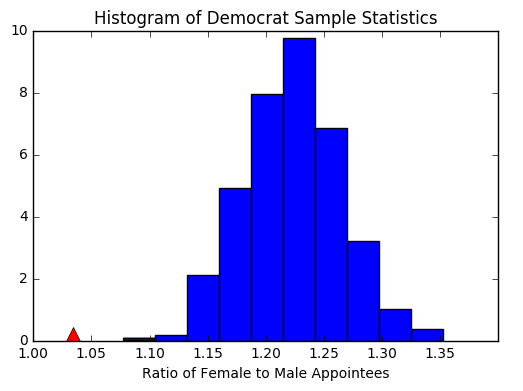

In [44]:
#dems
dem_stats = []
rep_stats = []
for _ in np.arange(1000):
    dem_m = sum(dem_sample_tbl['pop'].sample(n = total_dem, replace = True) == 'M')
    dem_f = total_dem - dem_m
    dem_stat = dem_f/dem_m
    dem_stats.append(dem_stat)

plt.hist(dem_stats, normed = True)
plt.plot(dem_pop_stat, 0.2, marker='^', markersize=10, color='red')
plt.xlabel('Ratio of Female to Male Appointees')
plt.title('Histogram of Democrat Sample Statistics');

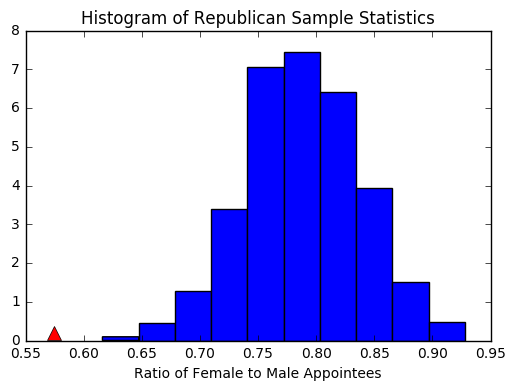

In [45]:
#gop
for _ in np.arange(1000) :   
    rep_m = sum(rep_sample_tbl['pop'].sample(n = total_rep, replace = True) == 'M')
    rep_f = total_rep - rep_m
    rep_stat = rep_f/rep_m
    rep_stats.append(rep_stat)
    
plt.hist(rep_stats, normed = True)
plt.plot(rep_pop_stat, 0.2, marker='^', markersize=10, color='red')
plt.xlabel('Ratio of Female to Male Appointees')
plt.title('Histogram of Republican Sample Statistics'); 

In [46]:
dem_p_val = sum(dem_stats <= dem_pop_stat)/len(dem_stats)
rep_p_val = sum(rep_stats <= rep_pop_stat)/len(rep_stats)
print('Dem p-value: %d' % (dem_p_val))
print('Rep p-value: %d' % (rep_p_val))
print('P-value less than 0.05 for both so we reject the null. That is, the ratio of female to male') 
print('appointees is more skewed in favor of men than can be explained by random chance.')

Dem p-value: 0
Rep p-value: 0
P-value less than 0.05 for both so we reject the null. That is, the ratio of female to male
appointees is more skewed in favor of men than can be explained by random chance.


In [ ]:
#frequency of press releases

In [25]:
import matplotlib.dates as mdates

In [26]:
#full_tbl['temp'] = all_dates
#full_tbl['month'] = full_tbl['temp'].apply(lambda x: str(x)[0:3])
#full_tbl['year'] = full_tbl['temp'].apply(lambda x: str(x)[-4:])
#full_tbl.drop('temp', axis = 1, inplace = True)
#grouped = full_tbl.groupby(['year', 'month']).count()
#fig, ax = plt.subplots()
#grouped.rename(columns = {'release_id': 'count'}).loc[:, ['count']].plot(figsize = (8,6), use_index = True)
#plt.title('Frequency of Press Releases');

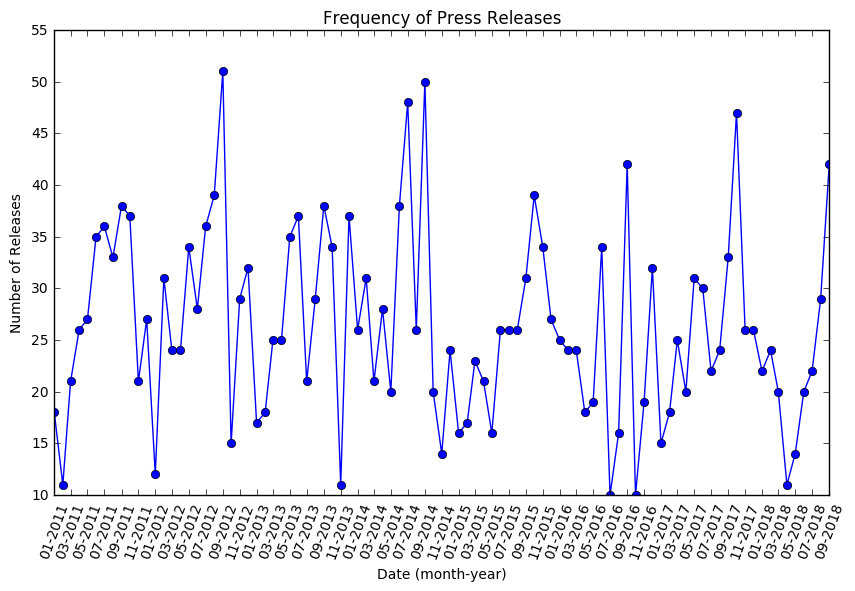

In [33]:
full_tbl['year_month'] = full_tbl['date'].apply(lambda x: str(x)[0:4] + str(x)[5:7])
grouped = (full_tbl.groupby('year_month').count().iloc[:-2].loc[:, ['release_id']]
           .rename(columns = {'release_id':'count'}))
grouped['date_to_plot'] = pd.to_datetime(grouped.index, format='%Y%m')

plt.plot(grouped['date_to_plot'], grouped['count'], '-o')
ax = plt.gca()
fig = plt.gcf()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.xticks(rotation = 70)
fig.set_figheight(6)
fig.set_figwidth(10)
plt.xlabel('Date (month-year)')
plt.ylabel('Number of Releases')
plt.title('Frequency of Press Releases');
